# Code Templates: LSTM Prediction Model
2024-2 SWCON314

In [1]:
# 히든레이어 100 -> 200

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, ConcatDataset

import glob
from tqdm import tqdm

from LSTMModel import LSTMModel

In [3]:
# Hyperparameters
TIME_STEP = 20
STRIDE = 1
INPUT_SIZE = 24
OUTPUT_SIZE = 1
BATCH_SIZE = 161
HIDDEN_LAYER_SIZE = 400
EPOCHS = 400
LEARNNG_RATE = 0.0007

# path and filename to save trained model
OUTPUT_FILENAME = 'model/free_12.pth'

# path to dataset
DATA_PATH = 'data'

# selecting columns from dataset csv file
x_features = [i for i in range(24)]
y_features = [48]

csv_file_paths = glob.glob(f'{DATA_PATH}/**/*.csv', recursive=True)
for path in csv_file_paths:
    print(path)

cuda_available = torch.cuda.is_available()
print(cuda_available)

data\free\free1\2_rear.csv
data\free\free1\4_rear.csv
data\free\free1\6_rear.csv
data\free\free2\2_rear.csv
data\free\free2\4_rear.csv
data\free\free3\2_rear.csv
data\free\free3\4_rear.csv
data\free\free3\6_rear.csv
data\free\free4\2_rear.csv
data\free\free4\4_rear.csv
data\free\free4\6_rear.csv
data\free\free5\2_rear.csv
data\free\free5\4_rear.csv
data\free\free5\6_rear.csv
data\free\free6\12.csv
data\free\free6\4.csv
data\free\free6\8.csv
data\free\free7\1.csv
data\free\free7\4.csv
data\free\free7\8.csv
data\free\free8\10.csv
data\free\free8\4.csv
data\free\free8\8.csv
data\free\free9\12.csv
data\free\free9\4.csv
data\free\free9\8.csv
True


In [4]:
def preprocess_file(file_path,  time_steps):
    data = pd.read_csv(file_path)
    X_features = data.values[:, x_features]
    y_target = data.values[:, y_features]
    X, y = create_dataset(X_features, y_target, time_steps)
    return X, y

def create_dataset(X, y, time_steps, stride=STRIDE):
    Xs, ys = [], []
    for i in range(0, len(X) - time_steps, stride):  # i의 증가량을 stride로 조정 -> sequence에서 시작 index를 stride 숫자씩 옮겨가며 시작 index ~ index + time_step만큼의 열을 추출
        v = X[i:(i + time_steps)]   # input feature data sequence
        Xs.append(v)
        ys.append(y[i + time_steps])

    return np.array(Xs), np.array(ys)

def load_and_process_data(file_paths, time_steps, batch_size=16):
    all_X, all_y = [], []
    
    for file_path in file_paths:
        # 파일별 데이터 처리
        X, y = preprocess_file(file_path, time_steps)
        all_X.append(X)
        all_y.append(y)
    
    # 모든 데이터를 하나로 합침
    combined_X = np.concatenate(all_X, axis=0)
    combined_y = np.concatenate(all_y, axis=0)
    
    # 데이터 분할
    X_train, X_val, y_train, y_val = train_test_split(
        combined_X, combined_y, test_size=0.1, random_state=42)
    
    # DataLoader 생성
    train_loader = DataLoader(TensorDataset(
        torch.tensor(X_train, dtype=torch.float32),
        torch.tensor(y_train, dtype=torch.float32)),
        batch_size=batch_size,
        shuffle=True)
    val_loader = DataLoader(TensorDataset(
        torch.tensor(X_val, dtype=torch.float32),
        torch.tensor(y_val, dtype=torch.float32)),
        batch_size=batch_size,
        shuffle=False)
    
    return train_loader, val_loader

def create_final_loaders(csv_file_paths, time_steps, batch_size):
    # csv_file_paths 분할
    subsets = [csv_file_paths[x:x+100] for x in range(0, len(csv_file_paths), 100)]

    # 각 서브셋에 대한 DataLoader 리스트 초기화
    train_loaders = []
    valid_loaders = []

    # 각 서브셋에 대해 DataLoader 생성 및 리스트에 추가
    for subset in subsets:
        train_loader, valid_loader = load_and_process_data(
            subset,
            time_steps=time_steps,
            batch_size=batch_size)
        train_loaders.append(train_loader)
        valid_loaders.append(valid_loader)

    # DataLoader들을 합친 최종 DataLoader 생성
    final_train_loader = DataLoader(ConcatDataset(
        [loader.dataset for loader in train_loaders]),
        batch_size=batch_size,
        shuffle=True)
    final_valid_loader = DataLoader(ConcatDataset(
        [loader.dataset for loader in valid_loaders]),
        batch_size=batch_size,
        shuffle=False)

    return final_train_loader, final_valid_loader

trainloader, validloader = create_final_loaders(
    csv_file_paths, time_steps=TIME_STEP, batch_size=BATCH_SIZE)

In [5]:
model = LSTMModel(input_size=INPUT_SIZE, hidden_layer_size=HIDDEN_LAYER_SIZE, output_size=OUTPUT_SIZE)   

## if you have GPU
if cuda_available:
    model.cuda()

epochs = EPOCHS
best_val_rmse = float('inf')
criterion = nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNNG_RATE)
for epoch in range(epochs):
    model.train()
    train_loss= 0
    for X_batch, y_batch in tqdm(trainloader, desc=f"Epoch {epoch+1}/{epochs} Training"):

        ## if you have GPU
        if cuda_available:
            X_batch, y_batch = X_batch.cuda(), y_batch.cuda()

        ####### LSTM ########
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step() 
        train_loss += loss.item()

    # run validation every 5 epochs
    if epoch % 5 == 0 or epoch == epochs-1:

        model.eval()

        val_rmse = []
        y_preds = []
        y_actuals = []
        with torch.no_grad():
            for X_batch, y_batch in tqdm(validloader, desc=f"Epoch {epoch+1}/{epochs} Validation"):

                ## if you have GPU
                if cuda_available:
                    X_batch, y_batch = X_batch.cuda(), y_batch.cuda()

                # inference the model
                y_pred = model(X_batch)

                # calculate RMSE
                rmse = torch.sqrt(criterion(y_pred, y_batch)).cpu().numpy()
                val_rmse.append(rmse)

                # for the first batch
                if len(y_preds) == 0:  
                    y_preds = y_pred.cpu().numpy()
                    y_actuals = y_batch.cpu().numpy()
                # for the rest of the batches
                else:  
                    y_preds = np.vstack((y_preds, y_pred.cpu().numpy()))
                    y_actuals = np.vstack((y_actuals, y_batch.cpu().numpy()))

        epoch_val_rmse = np.mean(val_rmse)
        print(f"Epoch {epoch+1}, Validation RMSE: {epoch_val_rmse}")

        if epoch_val_rmse < best_val_rmse:
            best_val_rmse = epoch_val_rmse
            print(f"New best model with RMSE: {best_val_rmse}, saving model...")
            torch.save(model.state_dict(), OUTPUT_FILENAME)

Epoch 1/400 Validation: 100%|██████████| 27/27 [00:00<00:00, 397.04it/s]


Epoch 1, Validation RMSE: 0.003461070591583848
New best model with RMSE: 0.003461070591583848, saving model...


Epoch 6/400 Validation: 100%|██████████| 27/27 [00:00<00:00, 437.56it/s]


Epoch 6, Validation RMSE: 0.002855537459254265
New best model with RMSE: 0.002855537459254265, saving model...


Epoch 11/400 Validation: 100%|██████████| 27/27 [00:00<00:00, 489.00it/s]


Epoch 11, Validation RMSE: 0.002569824457168579
New best model with RMSE: 0.002569824457168579, saving model...


Epoch 16/400 Validation: 100%|██████████| 27/27 [00:00<00:00, 324.79it/s]


Epoch 16, Validation RMSE: 0.002427655505016446
New best model with RMSE: 0.002427655505016446, saving model...


Epoch 21/400 Validation: 100%|██████████| 27/27 [00:00<00:00, 448.68it/s]


Epoch 21, Validation RMSE: 0.0029542192351073027


Epoch 26/400 Validation: 100%|██████████| 27/27 [00:00<00:00, 506.74it/s]


Epoch 26, Validation RMSE: 0.0020805613603442907
New best model with RMSE: 0.0020805613603442907, saving model...


Epoch 31/400 Validation: 100%|██████████| 27/27 [00:00<00:00, 516.41it/s]


Epoch 31, Validation RMSE: 0.0019833985716104507
New best model with RMSE: 0.0019833985716104507, saving model...


Epoch 36/400 Validation: 100%|██████████| 27/27 [00:00<00:00, 532.99it/s]


Epoch 36, Validation RMSE: 0.001833421876654029
New best model with RMSE: 0.001833421876654029, saving model...


Epoch 41/400 Validation: 100%|██████████| 27/27 [00:00<00:00, 462.81it/s]


Epoch 41, Validation RMSE: 0.0016996979247778654
New best model with RMSE: 0.0016996979247778654, saving model...


Epoch 46/400 Validation: 100%|██████████| 27/27 [00:00<00:00, 496.02it/s]


Epoch 46, Validation RMSE: 0.00130919658113271
New best model with RMSE: 0.00130919658113271, saving model...


Epoch 51/400 Validation: 100%|██████████| 27/27 [00:00<00:00, 516.16it/s]


Epoch 51, Validation RMSE: 0.0011404315009713173
New best model with RMSE: 0.0011404315009713173, saving model...


Epoch 56/400 Validation: 100%|██████████| 27/27 [00:00<00:00, 468.33it/s]


Epoch 56, Validation RMSE: 0.0009484551846981049
New best model with RMSE: 0.0009484551846981049, saving model...


Epoch 61/400 Validation: 100%|██████████| 27/27 [00:00<00:00, 488.36it/s]


Epoch 61, Validation RMSE: 0.000905752123799175
New best model with RMSE: 0.000905752123799175, saving model...


Epoch 66/400 Validation: 100%|██████████| 27/27 [00:00<00:00, 524.66it/s]


Epoch 66, Validation RMSE: 0.0008151043439283967
New best model with RMSE: 0.0008151043439283967, saving model...


Epoch 71/400 Validation: 100%|██████████| 27/27 [00:00<00:00, 463.90it/s]


Epoch 71, Validation RMSE: 0.0006594270817004144
New best model with RMSE: 0.0006594270817004144, saving model...


Epoch 76/400 Validation: 100%|██████████| 27/27 [00:00<00:00, 330.73it/s]


Epoch 76, Validation RMSE: 0.0006626517861150205


Epoch 81/400 Validation: 100%|██████████| 27/27 [00:00<00:00, 481.06it/s]


Epoch 81, Validation RMSE: 0.0005810577422380447
New best model with RMSE: 0.0005810577422380447, saving model...


Epoch 86/400 Validation: 100%|██████████| 27/27 [00:00<00:00, 364.80it/s]


Epoch 86, Validation RMSE: 0.0006165453232824802


Epoch 91/400 Validation: 100%|██████████| 27/27 [00:00<00:00, 503.87it/s]


Epoch 91, Validation RMSE: 0.0005308342515490949
New best model with RMSE: 0.0005308342515490949, saving model...


Epoch 96/400 Validation: 100%|██████████| 27/27 [00:00<00:00, 502.89it/s]


Epoch 96, Validation RMSE: 0.000503859540913254
New best model with RMSE: 0.000503859540913254, saving model...


Epoch 101/400 Validation: 100%|██████████| 27/27 [00:00<00:00, 488.31it/s]


Epoch 101, Validation RMSE: 0.0005575898103415966


Epoch 106/400 Validation: 100%|██████████| 27/27 [00:00<00:00, 539.62it/s]


Epoch 106, Validation RMSE: 0.0004470303829293698
New best model with RMSE: 0.0004470303829293698, saving model...


Epoch 111/400 Validation: 100%|██████████| 27/27 [00:00<00:00, 486.76it/s]


Epoch 111, Validation RMSE: 0.00043486777576617897
New best model with RMSE: 0.00043486777576617897, saving model...


Epoch 116/400 Validation: 100%|██████████| 27/27 [00:00<00:00, 438.34it/s]


Epoch 116, Validation RMSE: 0.00043897086288779974


Epoch 121/400 Validation: 100%|██████████| 27/27 [00:00<00:00, 510.72it/s]


Epoch 121, Validation RMSE: 0.0011610828805714846


Epoch 126/400 Validation: 100%|██████████| 27/27 [00:00<00:00, 510.47it/s]


Epoch 126, Validation RMSE: 0.00038871276774443686
New best model with RMSE: 0.00038871276774443686, saving model...


Epoch 131/400 Validation: 100%|██████████| 27/27 [00:00<00:00, 467.55it/s]


Epoch 131, Validation RMSE: 0.00040224535041488707


Epoch 136/400 Validation: 100%|██████████| 27/27 [00:00<00:00, 509.53it/s]


Epoch 136, Validation RMSE: 0.00035991196637041867
New best model with RMSE: 0.00035991196637041867, saving model...


Epoch 141/400 Validation: 100%|██████████| 27/27 [00:00<00:00, 541.80it/s]


Epoch 141, Validation RMSE: 0.00038710329681634903


Epoch 146/400 Validation: 100%|██████████| 27/27 [00:00<00:00, 488.01it/s]


Epoch 146, Validation RMSE: 0.00037600102950818837


Epoch 151/400 Validation: 100%|██████████| 27/27 [00:00<00:00, 465.60it/s]


Epoch 151, Validation RMSE: 0.00035999639658257365


Epoch 156/400 Validation: 100%|██████████| 27/27 [00:00<00:00, 479.85it/s]


Epoch 156, Validation RMSE: 0.00036097888369113207


Epoch 161/400 Validation: 100%|██████████| 27/27 [00:00<00:00, 412.07it/s]


Epoch 161, Validation RMSE: 0.00033203899511136115
New best model with RMSE: 0.00033203899511136115, saving model...


Epoch 166/400 Validation: 100%|██████████| 27/27 [00:00<00:00, 482.43it/s]


Epoch 166, Validation RMSE: 0.0005872600595466793


Epoch 171/400 Validation: 100%|██████████| 27/27 [00:00<00:00, 463.13it/s]


Epoch 171, Validation RMSE: 0.00031450725509785116
New best model with RMSE: 0.00031450725509785116, saving model...


Epoch 176/400 Validation: 100%|██████████| 27/27 [00:00<00:00, 376.52it/s]


Epoch 176, Validation RMSE: 0.0003356641682330519


Epoch 181/400 Validation: 100%|██████████| 27/27 [00:00<00:00, 501.19it/s]


Epoch 181, Validation RMSE: 0.0003073785628657788
New best model with RMSE: 0.0003073785628657788, saving model...


Epoch 186/400 Validation: 100%|██████████| 27/27 [00:00<00:00, 515.66it/s]


Epoch 186, Validation RMSE: 0.00033701767097227275


Epoch 191/400 Validation: 100%|██████████| 27/27 [00:00<00:00, 516.29it/s]


Epoch 191, Validation RMSE: 0.00029785442166030407
New best model with RMSE: 0.00029785442166030407, saving model...


Epoch 196/400 Validation: 100%|██████████| 27/27 [00:00<00:00, 438.90it/s]


Epoch 196, Validation RMSE: 0.0003133365826215595


Epoch 201/400 Validation: 100%|██████████| 27/27 [00:00<00:00, 496.04it/s]


Epoch 201, Validation RMSE: 0.0002978720294777304


Epoch 206/400 Validation: 100%|██████████| 27/27 [00:00<00:00, 461.10it/s]


Epoch 206, Validation RMSE: 0.0002789224963635206
New best model with RMSE: 0.0002789224963635206, saving model...


Epoch 211/400 Validation: 100%|██████████| 27/27 [00:00<00:00, 510.67it/s]


Epoch 211, Validation RMSE: 0.0002965608728118241


Epoch 216/400 Validation: 100%|██████████| 27/27 [00:00<00:00, 497.36it/s]


Epoch 216, Validation RMSE: 0.0003490135131869465


Epoch 221/400 Validation: 100%|██████████| 27/27 [00:00<00:00, 500.42it/s]


Epoch 221, Validation RMSE: 0.00030546836205758154


Epoch 226/400 Validation: 100%|██████████| 27/27 [00:00<00:00, 488.83it/s]


Epoch 226, Validation RMSE: 0.0002750161802396178
New best model with RMSE: 0.0002750161802396178, saving model...


Epoch 231/400 Validation: 100%|██████████| 27/27 [00:00<00:00, 334.00it/s]


Epoch 231, Validation RMSE: 0.00026798105682246387
New best model with RMSE: 0.00026798105682246387, saving model...


Epoch 236/400 Validation: 100%|██████████| 27/27 [00:00<00:00, 520.45it/s]


Epoch 236, Validation RMSE: 0.00028059346368536353


Epoch 241/400 Validation: 100%|██████████| 27/27 [00:00<00:00, 481.00it/s]


Epoch 241, Validation RMSE: 0.00026600793353281915
New best model with RMSE: 0.00026600793353281915, saving model...


Epoch 246/400 Validation: 100%|██████████| 27/27 [00:00<00:00, 350.88it/s]


Epoch 246, Validation RMSE: 0.00029119011014699936


Epoch 251/400 Validation: 100%|██████████| 27/27 [00:00<00:00, 489.02it/s]


Epoch 251, Validation RMSE: 0.00026904483092948794


Epoch 256/400 Validation: 100%|██████████| 27/27 [00:00<00:00, 452.48it/s]


Epoch 256, Validation RMSE: 0.00028521704371087253


Epoch 261/400 Validation: 100%|██████████| 27/27 [00:00<00:00, 493.46it/s]


Epoch 261, Validation RMSE: 0.00028891413239762187


Epoch 266/400 Validation: 100%|██████████| 27/27 [00:00<00:00, 485.86it/s]


Epoch 266, Validation RMSE: 0.0002652754192240536
New best model with RMSE: 0.0002652754192240536, saving model...


Epoch 271/400 Validation: 100%|██████████| 27/27 [00:00<00:00, 457.66it/s]


Epoch 271, Validation RMSE: 0.00025838904548436403
New best model with RMSE: 0.00025838904548436403, saving model...


Epoch 276/400 Validation: 100%|██████████| 27/27 [00:00<00:00, 500.50it/s]


Epoch 276, Validation RMSE: 0.00026039514341391623


Epoch 281/400 Validation: 100%|██████████| 27/27 [00:00<00:00, 382.70it/s]


Epoch 281, Validation RMSE: 0.00025406834902241826
New best model with RMSE: 0.00025406834902241826, saving model...


Epoch 286/400 Validation: 100%|██████████| 27/27 [00:00<00:00, 345.84it/s]


Epoch 286, Validation RMSE: 0.0002388977591181174
New best model with RMSE: 0.0002388977591181174, saving model...


Epoch 291/400 Validation: 100%|██████████| 27/27 [00:00<00:00, 457.43it/s]


Epoch 291, Validation RMSE: 0.00024249278067145497


Epoch 296/400 Validation: 100%|██████████| 27/27 [00:00<00:00, 509.14it/s]


Epoch 296, Validation RMSE: 0.00024688191479071975


Epoch 301/400 Validation: 100%|██████████| 27/27 [00:00<00:00, 492.23it/s]


Epoch 301, Validation RMSE: 0.0002642487525008619


Epoch 306/400 Validation: 100%|██████████| 27/27 [00:00<00:00, 538.89it/s]


Epoch 306, Validation RMSE: 0.000251235265750438


Epoch 311/400 Validation: 100%|██████████| 27/27 [00:00<00:00, 483.86it/s]


Epoch 311, Validation RMSE: 0.00026470719603821635


Epoch 316/400 Validation: 100%|██████████| 27/27 [00:00<00:00, 438.06it/s]


Epoch 316, Validation RMSE: 0.0002368767891312018
New best model with RMSE: 0.0002368767891312018, saving model...


Epoch 321/400 Validation: 100%|██████████| 27/27 [00:00<00:00, 487.29it/s]


Epoch 321, Validation RMSE: 0.00023661319573875517
New best model with RMSE: 0.00023661319573875517, saving model...


Epoch 326/400 Validation: 100%|██████████| 27/27 [00:00<00:00, 497.07it/s]


Epoch 326, Validation RMSE: 0.00023922343098092824


Epoch 331/400 Validation: 100%|██████████| 27/27 [00:00<00:00, 455.41it/s]


Epoch 331, Validation RMSE: 0.00025304273003712296


Epoch 336/400 Validation: 100%|██████████| 27/27 [00:00<00:00, 320.43it/s]


Epoch 336, Validation RMSE: 0.00024203446810133755


Epoch 341/400 Validation: 100%|██████████| 27/27 [00:00<00:00, 474.48it/s]


Epoch 341, Validation RMSE: 0.0002377202472416684


Epoch 346/400 Validation: 100%|██████████| 27/27 [00:00<00:00, 445.70it/s]


Epoch 346, Validation RMSE: 0.00024738372303545475


Epoch 351/400 Validation: 100%|██████████| 27/27 [00:00<00:00, 501.81it/s]


Epoch 351, Validation RMSE: 0.00022886002261657268
New best model with RMSE: 0.00022886002261657268, saving model...


Epoch 356/400 Validation: 100%|██████████| 27/27 [00:00<00:00, 495.64it/s]


Epoch 356, Validation RMSE: 0.00023477160721085966


Epoch 361/400 Validation: 100%|██████████| 27/27 [00:00<00:00, 464.00it/s]


Epoch 361, Validation RMSE: 0.00022037557209841907
New best model with RMSE: 0.00022037557209841907, saving model...


Epoch 366/400 Validation: 100%|██████████| 27/27 [00:00<00:00, 501.46it/s]


Epoch 366, Validation RMSE: 0.00023171653447207063


Epoch 371/400 Validation: 100%|██████████| 27/27 [00:00<00:00, 474.49it/s]


Epoch 371, Validation RMSE: 0.0002288172981934622


Epoch 376/400 Validation: 100%|██████████| 27/27 [00:00<00:00, 473.40it/s]


Epoch 376, Validation RMSE: 0.0002322109357919544


Epoch 381/400 Validation: 100%|██████████| 27/27 [00:00<00:00, 543.08it/s]


Epoch 381, Validation RMSE: 0.0002251954865641892


Epoch 386/400 Validation: 100%|██████████| 27/27 [00:00<00:00, 547.86it/s]


Epoch 386, Validation RMSE: 0.0002231053076684475


Epoch 391/400 Validation: 100%|██████████| 27/27 [00:00<00:00, 506.51it/s]


Epoch 391, Validation RMSE: 0.00023566615709569305


Epoch 396/400 Validation: 100%|██████████| 27/27 [00:00<00:00, 434.57it/s]


Epoch 396, Validation RMSE: 0.00022546632681041956


Epoch 400/400 Validation: 100%|██████████| 27/27 [00:00<00:00, 409.74it/s]

Epoch 400, Validation RMSE: 0.00021862114954274148
New best model with RMSE: 0.00021862114954274148, saving model...


100%|██████████| 1208/1208 [00:00<00:00, 1348.08it/s]

RMSE avg: 0.004286288247552676


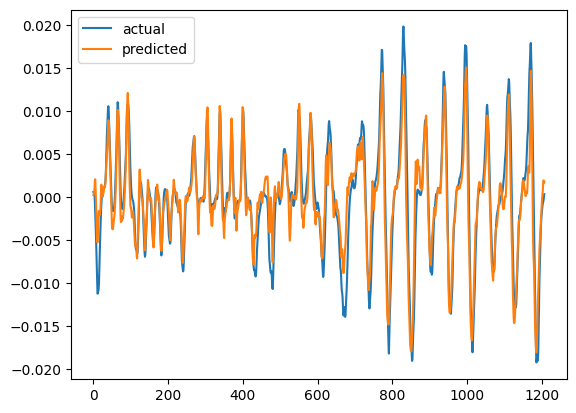

In [ ]:
import matplotlib.pyplot as plt

model.eval()
data = pd.read_csv(r'data/free/free1/4_rear.csv') # choice was arbitrary selection from the dataset 

X = data.values[:,x_features].astype(np.float32)
y = data.values[:,y_features].astype(np.float32)
y_pred = []

error_sum = 0
with torch.no_grad():
    for i in tqdm(range(X.shape[0]-5)):
        t = torch.Tensor(X[i:i+5])
        t = t.unsqueeze(0)

        ## if you have GPU
        if cuda_available:
            t = t.cuda()
        
        pred = model(t)
        pred = pred.cpu()
        pred = pred.squeeze().cpu()
        y_pred.append(pred.numpy())
        rmse = np.sqrt(np.sum((y[i] - pred.numpy()) ** 2) / y[i].size)
        error_sum += rmse

error_sum = error_sum / (X.shape[0]-5)
print(f'RMSE avg: {error_sum}')

plt.plot(y[5:], label='actual')
y_pred_arr = np.array(y_pred)
plt.plot(y_pred_arr, label='predicted')
plt.legend(loc='best')
plt.show(block=True)

In [ ]:
import torch.onnx

x = torch.Tensor(X[:TIME_STEP])
x = x.unsqueeze(0)
x = x.cuda()
torch.onnx.export(model, x, "model12.onnx", verbose=True, input_names=['input'], output_names=['output'], dynamic_axes={'input': {1: 'input_seq'}})

c:\Users\woook\anaconda3\envs\lstm_test\Lib\site-packages\torch\onnx\symbolic_opset9.py:4279: UserWarning: Exporting a model to ONNX with a batch_size other than 1, with a variable length with LSTM can cause an error when running the ONNX model with a different batch size. Make sure to save the model with a batch size of 1, or define the initial states (h0/c0) as inputs of the model. 
  warnings.warn(
